In [1]:
import torch
import transformer_lens
from transformer_lens import HookedTransformer
from transformer_lens import FactoredMatrix
import matplotlib.pyplot as plt

In [2]:
# Factored Matrices

In [3]:
A = torch.randn(3, 2)
B = torch.randn(2, 3)
AB = A @ B

In [4]:
AB_factor = FactoredMatrix(A, B)
print(AB.norm(), AB_factor.norm())
print(AB_factor.ldim, AB_factor.mdim, AB_factor.rdim)

C = torch.randn(3, 5)
ABC = AB @ C
ABC_factor = AB_factor @ C  # returns a factored matrix
print(ABC_factor.ldim, ABC_factor.mdim, ABC_factor.rdim)

tensor(2.0494) tensor(2.0494)
3 2 3
3 2 5


In [5]:
# eigen values and eigen vectors
print(torch.linalg.eig(AB).eigenvalues)
print(torch.linalg.eig(AB).eigenvectors)

# singular value decomposition
print(torch.linalg.svd(AB).S)
print(torch.linalg.svd(AB).U)
print(torch.linalg.svd(AB).Vh)

tensor([ 6.7939e-01+0.j, -2.9802e-08+0.j, -1.6742e+00+0.j])
tensor([[ 0.7845+0.j, -0.7397+0.j, -0.3233+0.j],
        [-0.3705+0.j, -0.4203+0.j, -0.9147+0.j],
        [-0.4972+0.j, -0.5254+0.j,  0.2425+0.j]])
tensor([1.9303e+00, 6.8854e-01, 2.5288e-09])
tensor([[-0.3104,  0.7789,  0.5450],
        [-0.9213, -0.3877,  0.0295],
        [ 0.2343, -0.4929,  0.8379]])
tensor([[-0.0190,  0.7936, -0.6081],
        [ 0.6726, -0.4399, -0.5951],
        [ 0.7397,  0.4203,  0.5254]])


In [6]:
# Reverse engineering circuits

In [7]:
# [1] OV copying circuit

In [8]:
model = HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [35]:
head_index = 4
layer = 1

W_O = model.W_O[layer, head_index]
W_V = model.W_V[layer, head_index]
W_E = model.W_E
W_U = model.W_U

OV_circuit = FactoredMatrix(W_V, W_O)
full_OV_circuit = W_E @ OV_circuit @ W_U

In [36]:
W_E.size()

torch.Size([50257, 768])

In [37]:
test_emb = torch.zeros(W_E.size()[0], device="cuda")
test_emb[0] = 1

In [41]:
(test_emb @ full_OV_circuit)

tensor([ 0.2074, -0.0177, -0.2028,  ..., -0.2610,  0.3026, -0.1220],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

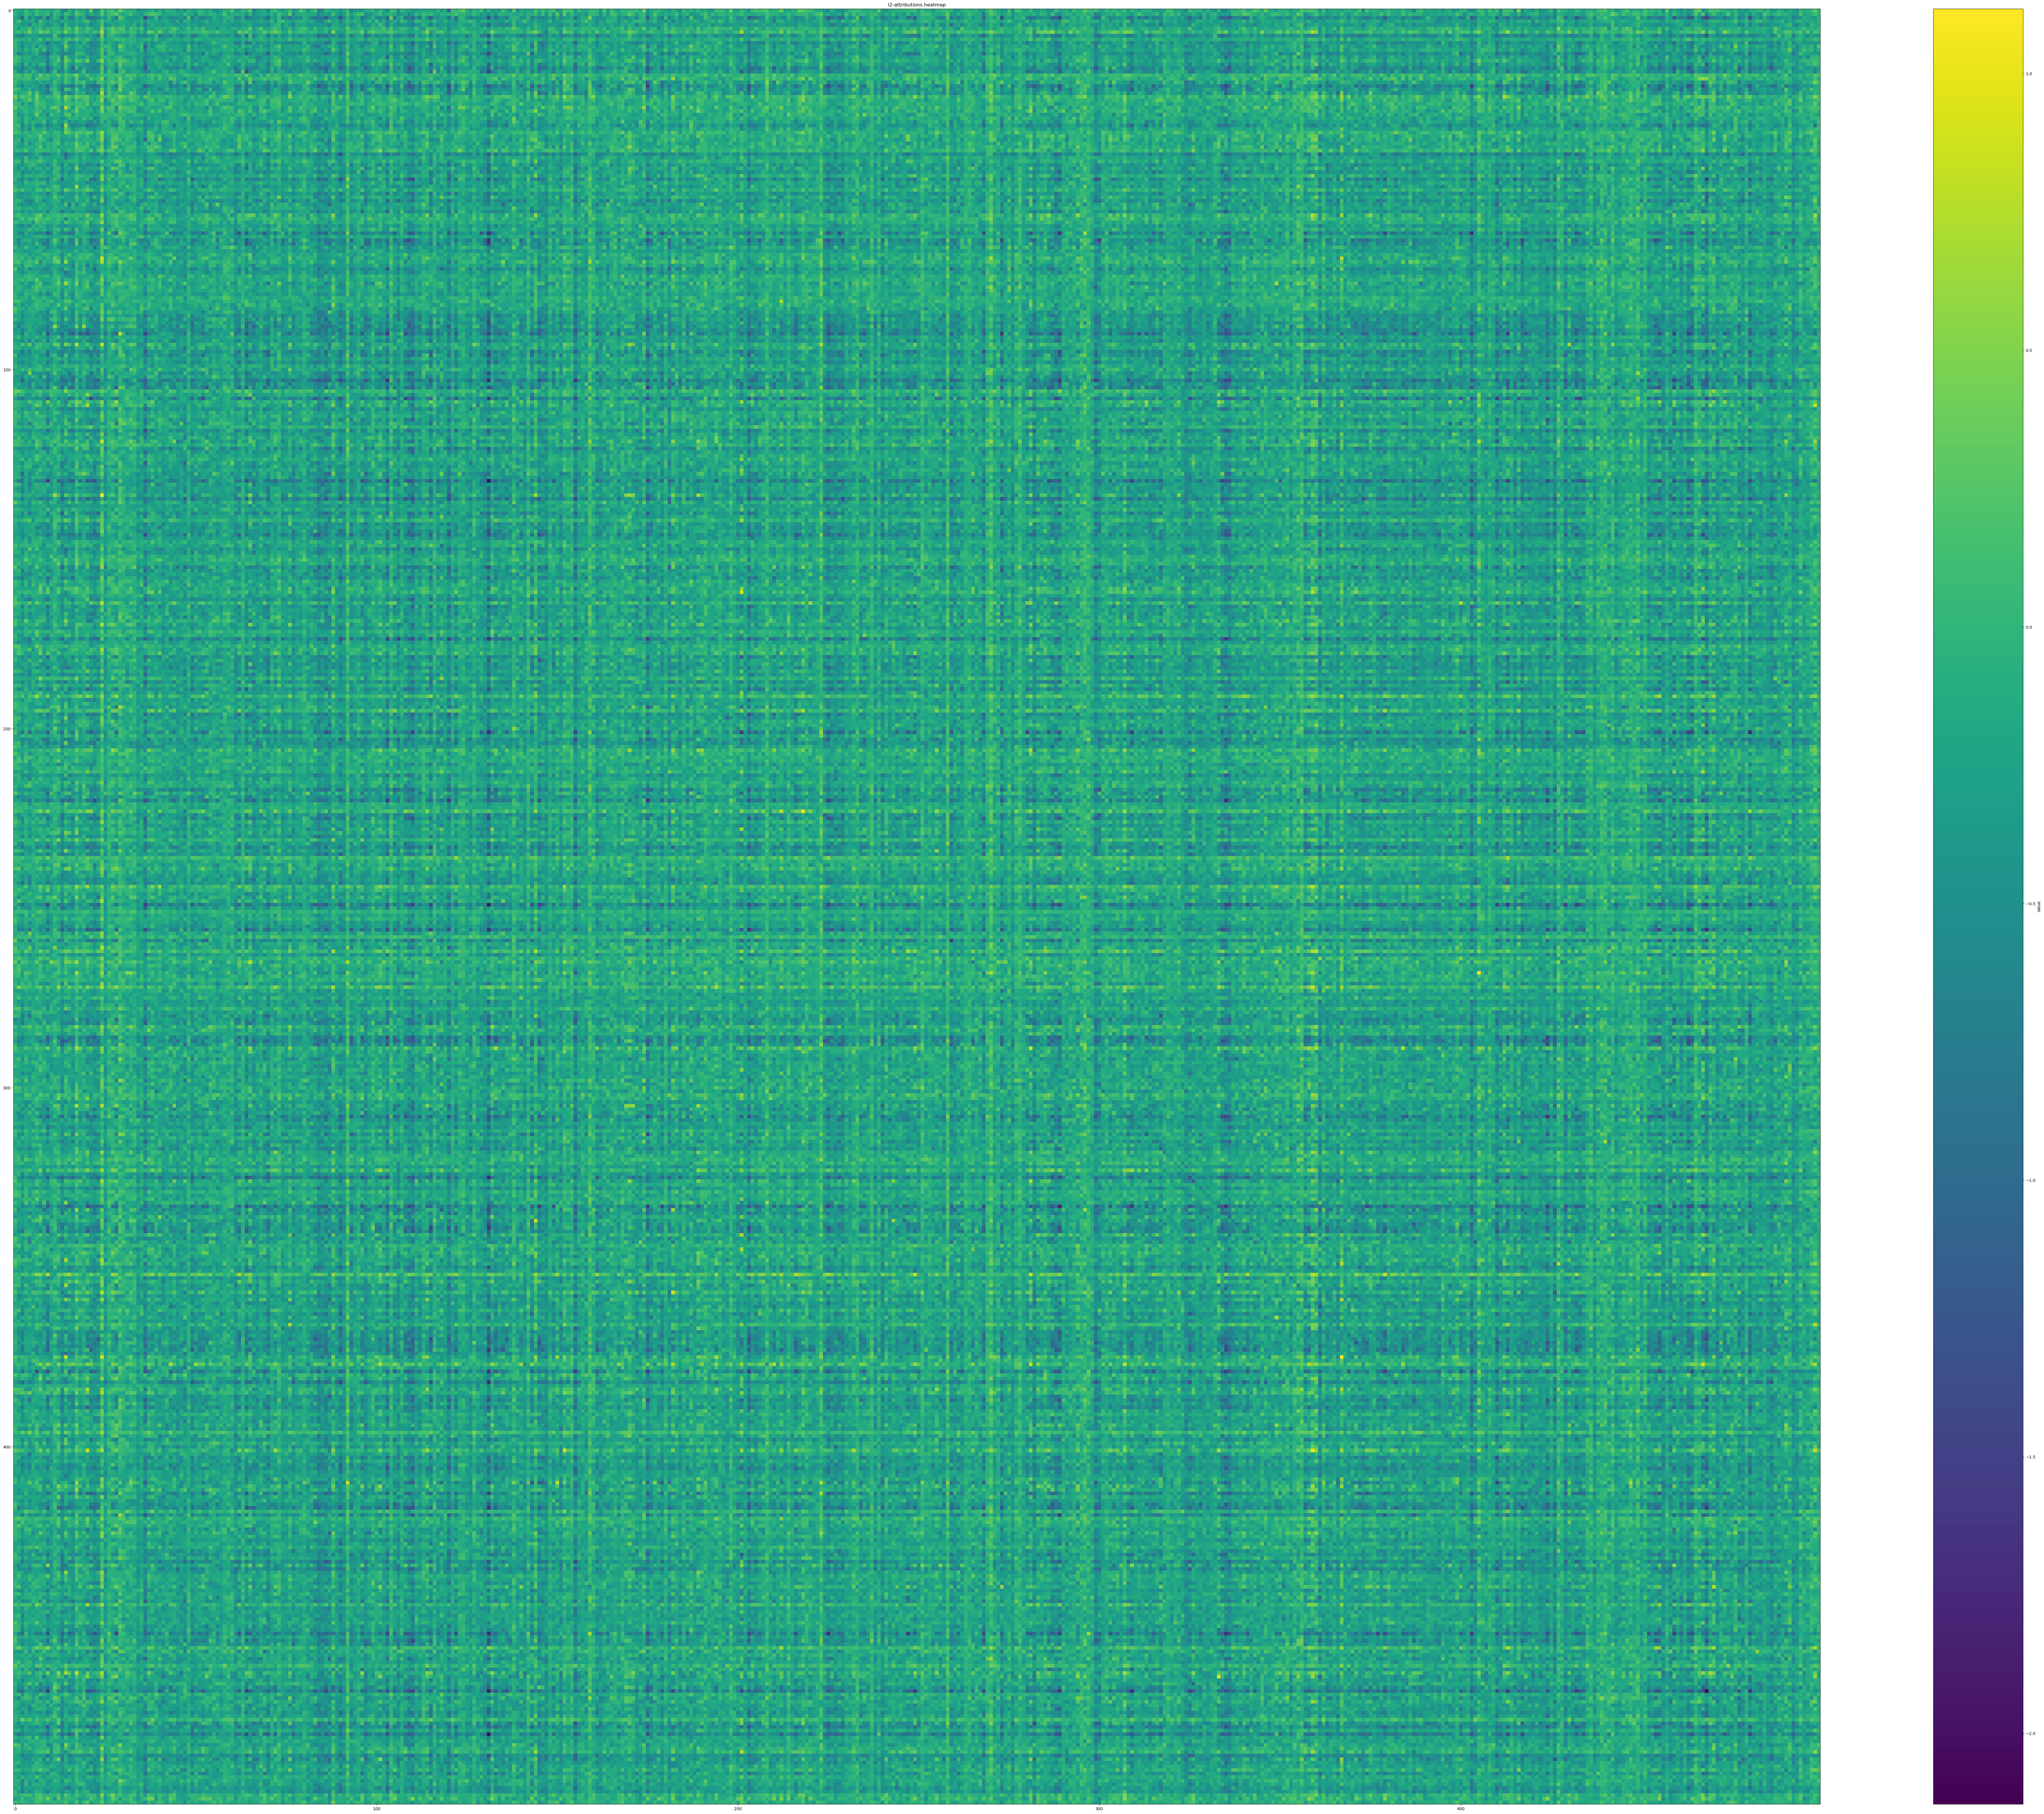

In [43]:
full_OV_circuit_cpu = full_OV_circuit[2000:2500, 2000:2500].detach().cpu().numpy()

plt.figure(figsize=(100, 80))
plt.imshow(full_OV_circuit_cpu, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('l2-attributions heatmap')

# Set ticks at every position
# plt.xticks(np.arange(fu.shape[1]))
# plt.yticks(np.arange(l2_attn_attribs_np.shape[0]))

plt.show()